In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys
sys.path.append("/home/jovyan/PACEfun")
import helper
from dask.distributed import Client


In [2]:
client = Client()
auth = earthaccess.login("login.netrc")


In [3]:
# --- TIME ---

tspan = ("2024-09-01 00:00", "2024-10-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = (21.058555012396997, 42.69174831596751)
ext = 1.5
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region


(19.558555012396997, 41.19174831596751, 22.558555012396997, 44.19174831596751)

In [4]:
results_spx = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_spx = earthaccess.open(results_spx)


QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
results_oci = earthaccess.search_data(
    short_name="PACE_OCI_L2_AER_UAA",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_oci = earthaccess.open(results_oci)


QUEUEING TASKS | :   0%|          | 0/52 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/52 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/52 [00:00<?, ?it/s]

In [6]:
wv = 550
wv_idx = helper.get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = helper.crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = helper.grid_aligned_subset(region, transform_tmp, shape_tmp)


In [7]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs)
futures = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx["time"] = attrs["time"]


In [8]:
wv = 550
wv_idx = 550
crs, shape_tmp, transform_tmp = helper.crs_template(paths_oci[0], "Aerosol_Optical_Depth", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = helper.grid_aligned_subset(region, transform_tmp, shape_tmp)


In [9]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_oci, preprocess=helper.time_from_attr, **kwargs)
futures = client.map(
    helper.grid_match,
    paths_oci,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="Aerosol_Optical_Depth",
    wv_idx=wv_idx
)
da_oci = xr.combine_nested(client.gather(futures), concat_dim="time")
da_oci["time"] = attrs["time"]


In [10]:
#da_oci_matched = da_oci.reindex(
#    time=da_spx.time,
#    method="nearest",
#    tolerance="3H"
#)

da_oci_time_matched = da_oci.interp(time=da_spx["time"], method="nearest")
da_oci_matched = da_oci_time_matched.interp(
    longitude=da_spx["longitude"],
    latitude=da_spx["latitude"],
    method="linear"
)



In [ ]:
nc_path='/home/jovyan/nc_files'
da_spx.to_netcdf(f"{nc_path}/spx_aod.nc")
da_oci.to_netcdf(f"{nc_path}/oci_aod.nc")
da_oci_matched.to_netcdf(f"{nc_path}/oci_spx_aod.nc")
da_oci_time_matched.to_netcdf(f"{nc_path}/oci_spxTime_aod.nc")


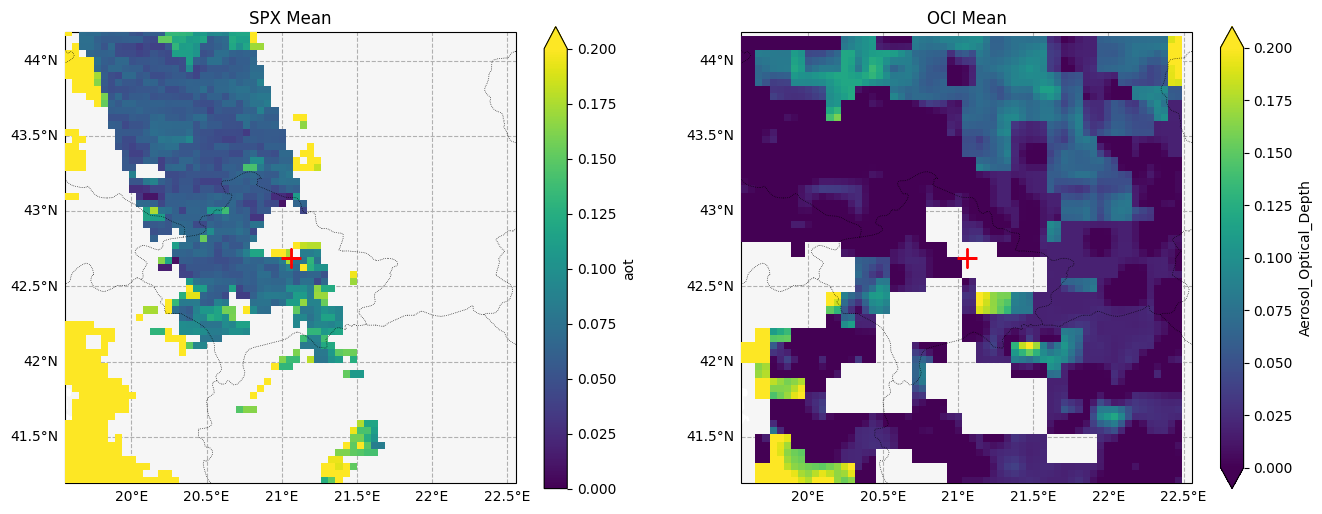

(<Figure size 1600x600 with 4 Axes>,
 array([<GeoAxes: title={'center': 'SPX Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <GeoAxes: title={'center': 'OCI Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>],
       dtype=object))

In [11]:
cross_lonlat = (21.058555012396997, 42.69174831596751)

# Static mean panel comparison using helper
helper.plot_mean_panels(
    [da_spx, da_oci_matched],
    region=region,
    titles=["SPX Mean", "OCI Mean"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=0.0,
    vmax=0.2,
    background=None,
    tiles_zoom=12,
)


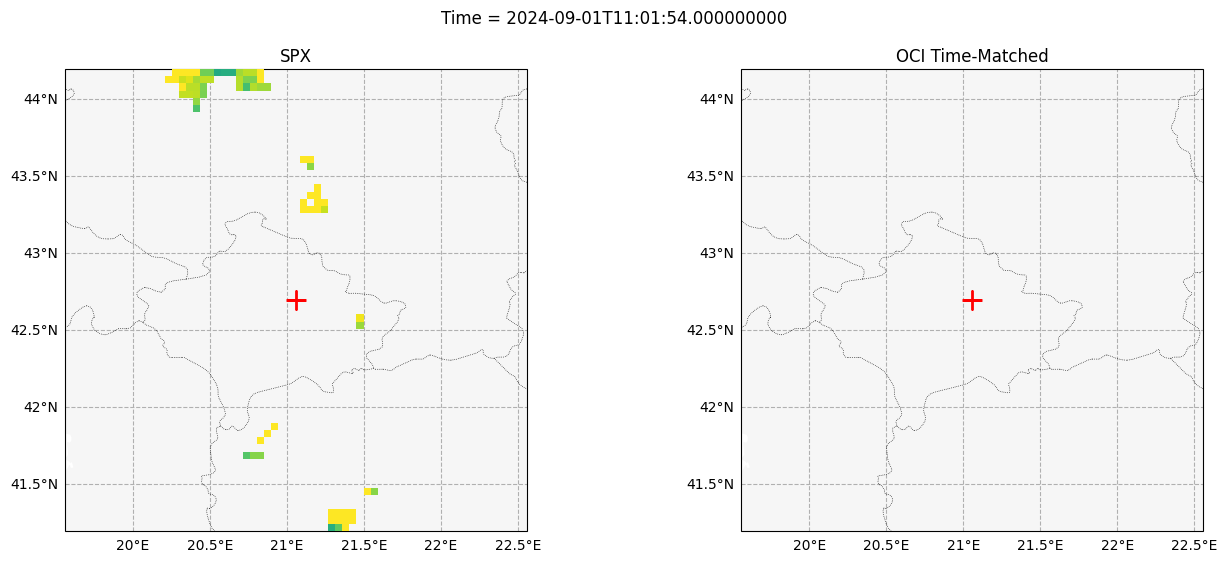

In [12]:
# Time animation using helper
_, _, ani = helper.animate_panels(
    [da_spx, da_oci_time_matched],
    region=region,
    titles=["SPX", "OCI Time-Matched"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=0.0,
    vmax=0.2,
    interval=600,
    save_path="PACEfun/movies/spx_oci_comparison.gif",
    writer="pillow",
    dpi=120,
)



In [13]:
# Interactive time slider (Jupyter) using helper
helper.interactive_panels(
    [da_spx, da_oci_time_matched],
    region=region,
    titles=["SPX", "OCI Time-Matched"],
    crosshair=cross_lonlat,
    vmin=0.0,
    vmax=0.2,
)





interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function helper.interactive_panels.<locals>.plot_frame(i)>